# Исследование экономической выгоды от пользователей с подпиской по месяцам и пользователей без подписки

В нашем распоряжении данные сервиса аренды самокатов GoFast -  данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
    
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 

3130 метров — оптимальное с точки зрения износа самоката. Проверим среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает ли оно 3130 метров? 

Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Проверим, снизилось ли колисество обращений в техническую поддержку после обновления сервера, с которым взаимодействует мобильное приложение. 


In [1]:
#Загрузим библиотеки
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import scipy.stats as st
from math import factorial
from scipy.stats import binom, norm

sns.set_theme(palette='Set2', style='whitegrid')

### Знакомство с данными

In [2]:
# откроем датасеты
try:
    users = pd.read_csv('assets/users_go.csv') # информация о пользователях
    rides = pd.read_csv('assets/rides_go.csv') # информация о поездках
    # данные о подписках
    subscriptions = pd.read_csv('assets/subscriptions_go.csv') 
except:
    users = pd.read_csv('/datasets/users_go.csv') 
    rides = pd.read_csv('/datasets/rides_go.csv') 
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
    
pd.set_option("display.max_columns", None)

print('Пользователи')
display(users.head(5))
print('Поездки')
display(rides.head(5))
print('Подписка')
display(subscriptions.head(5))

Пользователи


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


Поездки


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Подписка


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [3]:
# Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти
print("Пользователи \n")
print(users.info())

print('*'*60, '\n')

print('Поездки \n')
print(rides.info())

print('*'*60, '\n')

print('Подписка \n')
print(subscriptions.info())

Пользователи 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None
************************************************************ 

Поездки 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None
**********

In [4]:
# Оценим количество пропущенных значений в каждом столбце
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [5]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [6]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

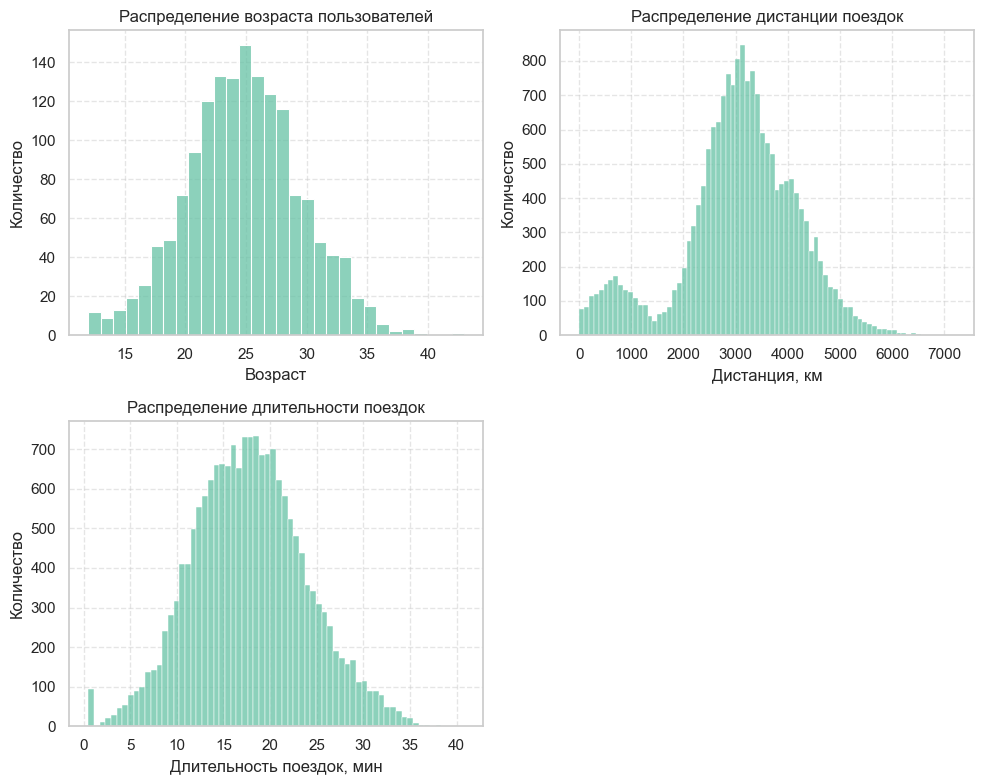

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8)) 
axes = axes.flatten()  # Преобразуем оси в плоский массив (для удобства)

# Гистограмма возраста пользователей
sns.histplot(users['age'], ax=axes[0])
axes[0].set_title('Распределение возраста пользователей')
axes[0].set_ylabel('Количество')
axes[0].set_xlabel('Возраст')


# Гистограмма дистанции поездок
sns.histplot(rides['distance'], ax=axes[1])
axes[1].set_title('Распределение дистанции поездок')
axes[1].set_ylabel('Количество')
axes[1].set_xlabel('Дистанция, км')


#Гистограмма длительности поездок
sns.histplot(rides['duration'], ax=axes[2])
axes[2].set_title('Распределение длительности поездок')
axes[2].set_ylabel('Количество')
axes[2].set_xlabel('Длительность поездок, мин')
axes[3].remove() 

for ax in axes[:3]: 
    ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout() 
plt.show()


Общая предварительная оценка данных:

- набор данных достаточен для анализа
- пропуски отсутсвуют
- присутсвуют неправильные типы данных

Выборка репрезентативна.


###  Предобработка данных

#### Удаление дубликатов

In [8]:
rides.duplicated().sum()

0

In [9]:
users.duplicated().sum()

31

In [10]:
# Удалими явные дубликаты в датасете users
users = users.drop_duplicates(keep = 'first')
users.duplicated().sum()

0

In [11]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

- явные дубликаты удалены 
- неявные дубликаты отсутсвуют

####  Изменение типа данных

Переведем в формат времени значение столбца date в датафрейме rides

In [12]:
rides['date_of_ride'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       18068 non-null  int64         
 1   distance      18068 non-null  float64       
 2   duration      18068 non-null  float64       
 3   date          18068 non-null  object        
 4   date_of_ride  18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 705.9+ KB


####  Добавление новых столбцов

In [13]:
# Добавим столбец c месяцем поездки
rides['month'] = pd.DatetimeIndex(rides['date_of_ride']).month
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       18068 non-null  int64         
 1   distance      18068 non-null  float64       
 2   duration      18068 non-null  float64       
 3   date          18068 non-null  object        
 4   date_of_ride  18068 non-null  datetime64[ns]
 5   month         18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(1)
memory usage: 776.5+ KB


In [14]:
rides.head()

,user_id,distance,duration,date,date_of_ride,month
0,1,4409.919140,25.599769,2021-01-01,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,2021-08-28,8


### Исследовательский анализ данных

Посмотрим на статистику выборки:

In [15]:
users.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


In [16]:
rides.describe()

,user_id,distance,duration,date_of_ride,month
count,18068.000000,18068.000000,18068.000000,18068,18068.000000
mean,842.869936,3070.659976,17.805011,2021-06-30 19:47:21.266327296,6.486772
min,1.000000,0.855683,0.500000,2021-01-01 00:00:00,1.000000
25%,487.000000,2543.226360,13.597563,2021-04-02 00:00:00,4.000000
50%,889.000000,3133.609994,17.678395,2021-06-30 00:00:00,6.000000
75%,1213.250000,3776.222735,21.724800,2021-09-28 00:00:00,9.000000
max,1534.000000,7211.007745,40.823963,2021-12-30 00:00:00,12.000000
std,434.734317,1116.831209,6.091051,NaN,3.437410


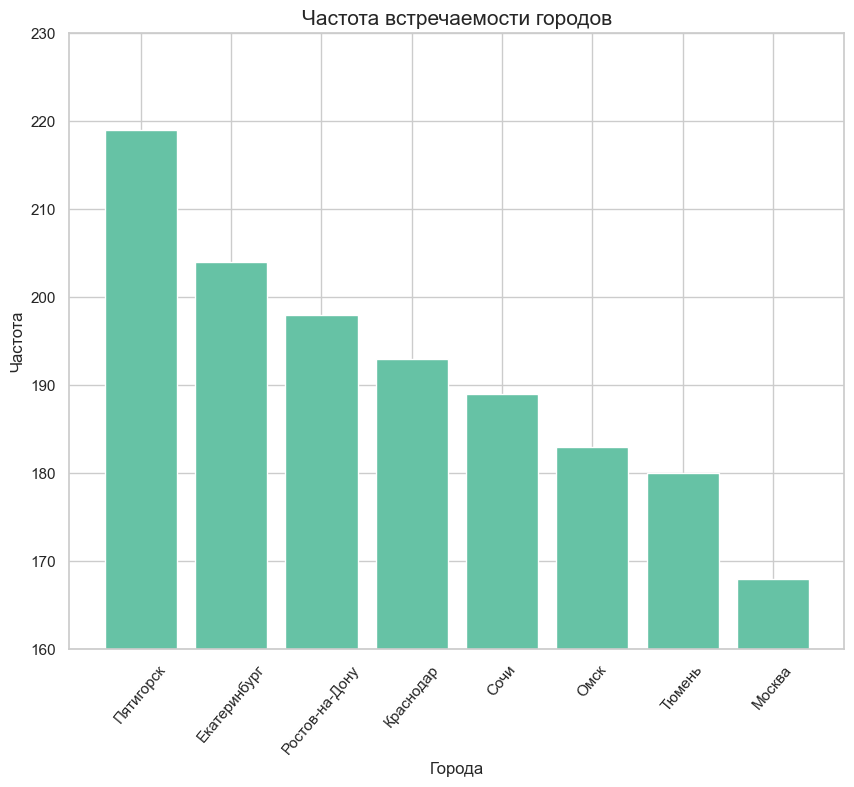

In [17]:
# Частота встречаемости городов
city_plot = users['city'].value_counts()



fig = plt.figure(figsize = (10,8))
ax_1 = fig.add_subplot(1,1,1) 
plt.bar(x=city_plot.index, height=city_plot.values)
ax_1.set_title('Частота встречаемости городов', fontsize = 15)
ax_1.set_xlabel('Города') 
ax_1.set_ylabel('Частота')
ax_1.grid(True)
ax_1 = plt.xticks(rotation = 50)
ax_1 = plt.ylim(160, 230)

plt.show()

- Больше всего поездок в Пятигорске
- Меньше всего в Москве

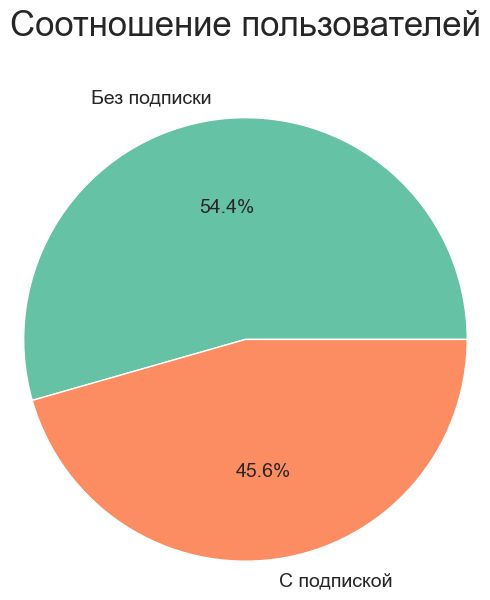

In [18]:
# Соотношение пользователей с подпиской и без подписки 
fig, ax = plt.subplots()

labels = ['Без подписки','С подпиской']
ax.pie(users['subscription_type'].value_counts(), 
       labels= labels , 
       autopct='%1.1f%%', 
       radius = 1.5, 
       textprops={'fontsize': 14})
ax.set_title('Соотношение пользователей', fontsize = 25, y = 1.3)
plt.show()

- Пользователей <u>без подписки</u> больше.

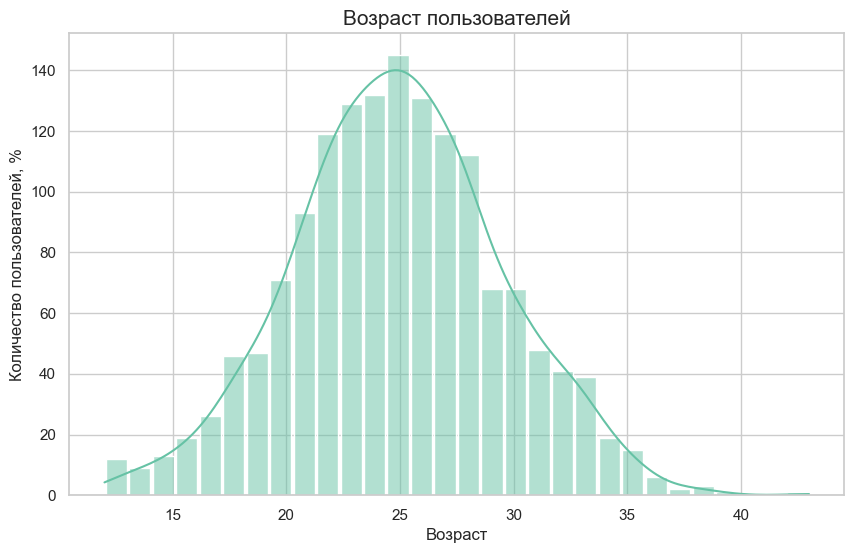

In [19]:
# Возраст пользователей

fig = plt.figure(figsize = (10,6)) # задаем размер изображения
ax_3 = sns.histplot(users, x='age', shrink=.9, kde=True)
ticks = []
for i in range (10,45):
    ticks.append(i)

ax_3.set_title('Возраст пользователей', fontsize= 15)
ax_3.set_xlabel('Возраст') 
ax_3.set_ylabel('Количество пользователей, %')

plt.show()

In [20]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

- Возраст пользователей от 12 до 43 лет
- Мода - 25 лет

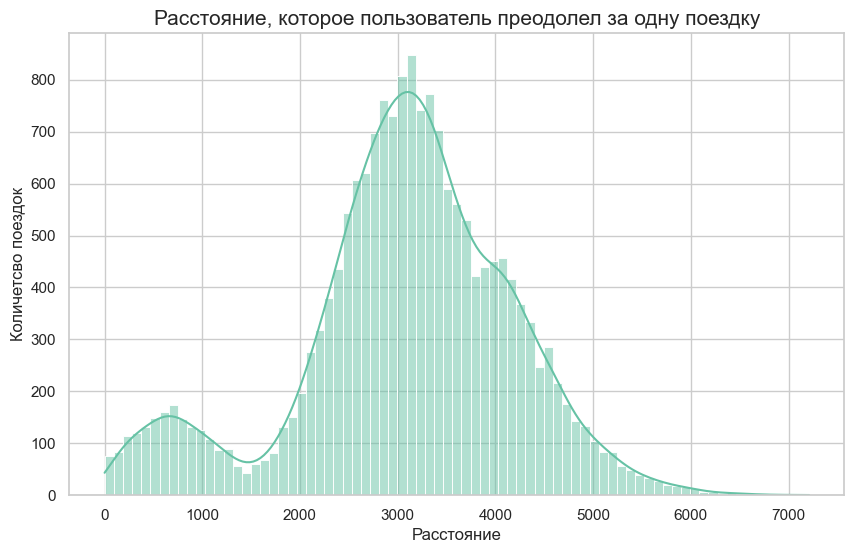

In [21]:
# Расстояние, которое пользователь преодолел за одну поездку;
fig = plt.figure(figsize = (10,6)) # задаем размер изображения 
ax_4 = sns.histplot(rides, x='distance', kde=True)
ax_4.set_title('Расстояние, которое пользователь преодолел за одну поездку', fontsize = 15)
ax_4.set_xlabel('Расстояние') 
ax_4.set_ylabel('Количетсво поездок')
ax_4.grid(True)
plt.show()

- Среднее расстояние поездки в районе 3км


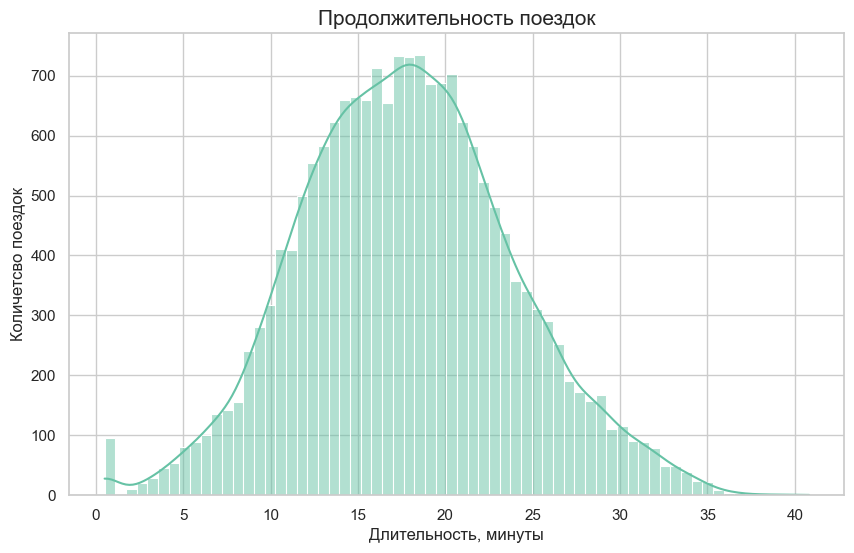

In [22]:
# Продолжительность поездок.

fig = plt.figure(figsize = (10,6)) # задаем размер изображения
ax_5 = sns.histplot(rides, x='duration', kde=True)
ax_5.set_title('Продолжительность поездок', fontsize= 15)
ax_5.set_xlabel('Длительность, минуты') 
ax_5.set_ylabel('Количетсво поездок')
ax_5.grid(True)

plt.show()

- Продолжительность поездок до 40 минут
- Среднее время 17 минут
- Пик около нуля (очень короткие поездки), скорее всего, говорит от технической неисправности и быстром завершении.

### Объединение данных


In [23]:
data = users.merge(rides, how = 'outer', left_on = 'user_id', right_on = 'user_id' )
data = data.merge(subscriptions, how = 'outer', left_on = 'subscription_type', right_on = 'subscription_type')
data.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,date_of_ride,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2021-02-14,2,8,50,0
5,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2021-02-23,2,8,50,0
6,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,2021-03-03,3,8,50,0
7,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,2021-04-09,4,8,50,0
8,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,2021-06-12,6,8,50,0
9,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,2021-06-23,6,8,50,0


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  object        
 8   date_of_ride       18068 non-null  datetime64[ns]
 9   month              18068 non-null  int32         
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(

Все три таблицы объединены в одну. 

Таблицы users и rides 'склеены' по user_id. 

Далее полученая таблица дополнена из таблицы subscriptions по столбцу subscription_type

In [25]:
# Из общего датасета выделим отдельно пользователей без подписки
data_free = data.query('subscription_type == "free"')
data_free['subscription_type'].unique()

array(['free'], dtype=object)

In [26]:
data_free.describe()

,user_id,age,distance,duration,date_of_ride,month,minute_price,start_ride_price,subscription_fee
count,11568.000000,11568.000000,11568.000000,11568.000000,11568,11568.000000,11568.0,11568.0,11568.0
mean,1120.527230,24.893326,3045.495282,17.390909,2021-07-01 21:47:03.236514560,6.522994,8.0,50.0,0.0
min,700.000000,12.000000,0.855683,0.500000,2021-01-01 00:00:00,1.000000,8.0,50.0,0.0
25%,915.000000,22.000000,2366.562689,12.958437,2021-04-02 00:00:00,4.000000,8.0,50.0,0.0
50%,1123.000000,25.000000,3114.648465,17.326890,2021-07-01 00:00:00,7.000000,8.0,50.0,0.0
75%,1328.000000,28.000000,3905.697894,21.594071,2021-09-30 00:00:00,9.000000,8.0,50.0,0.0
max,1534.000000,43.000000,7211.007745,34.948498,2021-12-30 00:00:00,12.000000,8.0,50.0,0.0
std,241.165628,4.481100,1246.173806,6.326803,NaN,3.449770,0.0,0.0,0.0


In [27]:
# Из общего датасета выделим отдельно пользователей с подпиской
data_ultra = data.query('subscription_type =="ultra"')
data_ultra['subscription_type'].unique()

array(['ultra'], dtype=object)

In [28]:
data_ultra.describe()

,user_id,age,distance,duration,date_of_ride,month,minute_price,start_ride_price,subscription_fee
count,6500.000000,6500.000000,6500.000000,6500.000000,6500,6500.000000,6500.0,6500.0,6500.0
mean,348.725385,24.892615,3115.445388,18.541985,2021-06-28 21:31:34.153846016,6.422308,6.0,0.0,199.0
min,1.000000,12.000000,244.210438,3.760353,2021-01-01 00:00:00,1.000000,6.0,0.0,199.0
25%,175.000000,22.000000,2785.444017,14.524654,2021-04-01 00:00:00,4.000000,6.0,0.0,199.0
50%,351.000000,25.000000,3148.637229,18.178153,2021-06-27 00:00:00,6.000000,6.0,0.0,199.0
75%,525.000000,28.000000,3560.574425,21.884129,2021-09-25 00:00:00,9.000000,6.0,0.0,199.0
max,699.000000,38.000000,5699.769662,40.823963,2021-12-30 00:00:00,12.000000,6.0,0.0,199.0
std,201.099339,4.757208,836.895330,5.572048,NaN,3.414616,0.0,0.0,0.0


data_free - датасет с информацией о пользователях без подписки

data_ultra - датасет с информацией о пользователях с подпиской

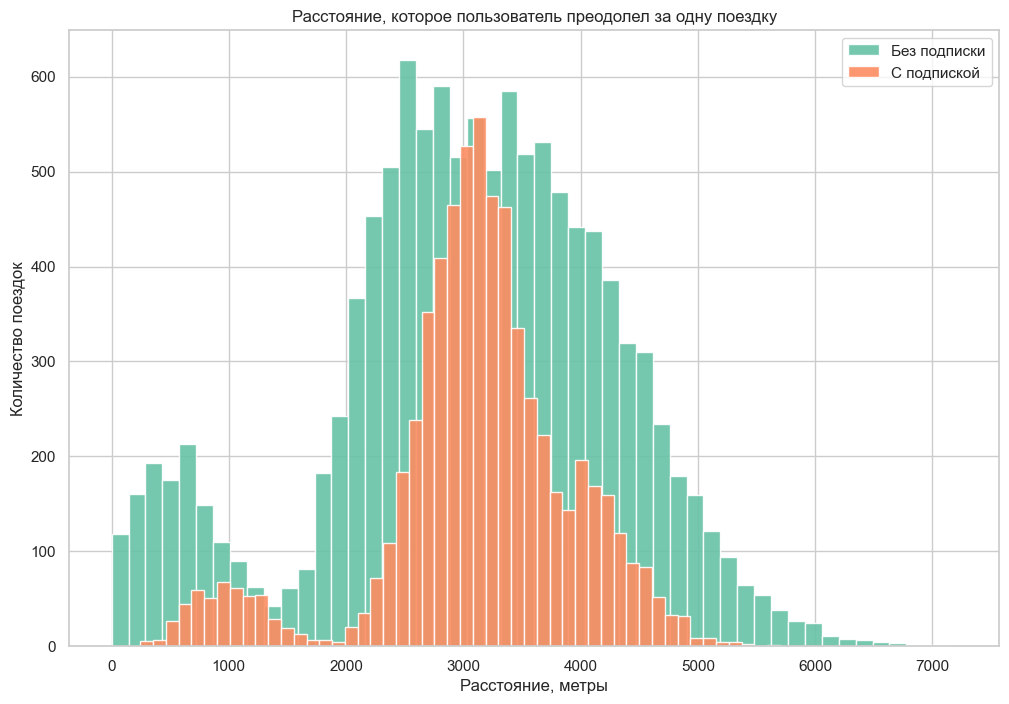

In [29]:
# Расстояние, которое пользователь преодолел за одну поездку;
plt.figure(figsize = (12,8))
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, метры')
plt.ylabel('Количество поездок')
plt.hist(data_free['distance'],bins= 50, alpha=0.9, label='Без подписки')
plt.hist(data_ultra['distance'], bins= 50, alpha=0.9, label='С подпиской')

# Добавляем легенду и выводим график на экран
plt.legend()
plt.show()


- Значения среднего расстояние для пользователей с подпиской и без совпадают
- Однако стандартное отклонение для пользователей без подписки выше.

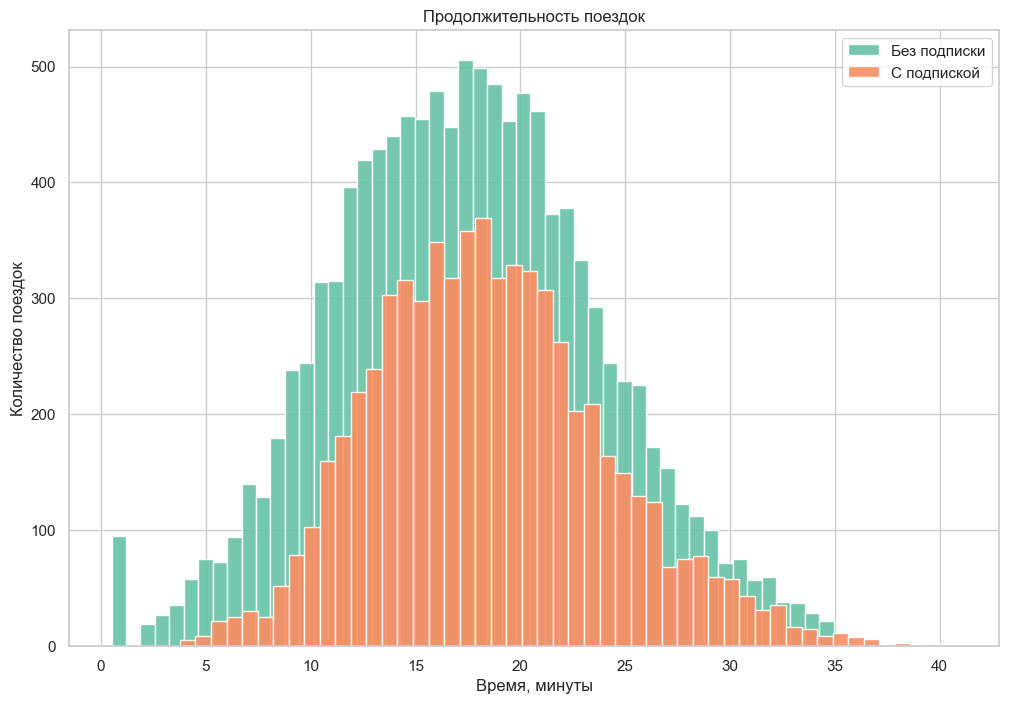

In [30]:
# Продолжительность поездок пользователей с подпиской и без;
plt.figure(figsize = (12,8))
plt.title('Продолжительность поездок')
plt.xlabel('Время, минуты')
plt.ylabel('Количество поездок')
plt.hist(data_free['duration'],bins= 50, alpha=0.9, label='Без подписки')
plt.hist(data_ultra['duration'], bins= 50, alpha=0.9, label='С подпиской')

# Добавляем легенду и выводим график на экран
plt.legend()
plt.show()


- Пик около нуля для пользователей без подписки скорее говорит о тех. проблемах с самокатом.
- Пользователи без подписки чаще используют самокаты на более короткое время

### Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе data с объединёнными данными.
Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [31]:
data['duration'] =  np.ceil(data['duration']) 
data_amount = pd.pivot_table(data, 
                             index=['user_id','month', 'subscription_type', 'minute_price',	'start_ride_price',	'subscription_fee'] , 
                             values=['distance', 'duration', 'city'], 
                             aggfunc={'distance': "sum", 'city': "count", 'duration': "sum"}).reset_index()
data_amount = data_amount.rename(columns={'city': 'quantity', 
                                          'distance': 'distance_amount',
                                          'duration': 'duration_amount'})
data_amount.head()

,user_id,month,subscription_type,minute_price,start_ride_price,subscription_fee,quantity,distance_amount,duration_amount
0,1,1,ultra,6,0,199,2,7027.511294,42.0
1,1,4,ultra,6,0,199,1,754.159807,7.0
2,1,8,ultra,6,0,199,2,6723.470560,46.0
3,1,10,ultra,6,0,199,2,5809.911100,32.0
4,1,11,ultra,6,0,199,3,7003.499363,56.0


In [32]:
data_amount.describe()

,user_id,month,minute_price,start_ride_price,subscription_fee,quantity,distance_amount,duration_amount
count,11331.000000,11331.000000,11331.000000,11331.000000,11331.000000,11331.000000,11331.000000,11331.000000
mean,811.061160,6.477539,7.199894,29.997352,79.610537,1.594564,4896.362584,29.186127
std,440.350798,3.443928,0.979861,24.496519,97.496144,0.831604,2911.516556,16.752464
min,1.000000,1.000000,6.000000,0.000000,0.000000,1.000000,2.570787,1.000000
25%,435.000000,4.000000,6.000000,0.000000,0.000000,1.000000,2972.202146,17.000000
50%,843.000000,6.000000,8.000000,50.000000,0.000000,1.000000,3988.723985,24.000000
75%,1191.000000,9.000000,8.000000,50.000000,199.000000,2.000000,6421.375890,38.000000
max,1534.000000,12.000000,8.000000,50.000000,199.000000,7.000000,23429.487786,143.000000


Расчитаем помесячную выручку, которую принёс каждый пользователь. 

Помесячная выручка считается по формуле: стоимость старта поездки × количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.

In [33]:
data_amount['revenue'] = np.ceil(data_amount['start_ride_price']*data_amount['quantity']    
                          + data_amount['minute_price']*data_amount['duration_amount']    
                          +data_amount['subscription_fee'])
data_amount.describe()

,user_id,month,minute_price,start_ride_price,subscription_fee,quantity,distance_amount,duration_amount,revenue
count,11331.000000,11331.000000,11331.000000,11331.000000,11331.000000,11331.000000,11331.000000,11331.000000,11331.000000
mean,811.061160,6.477539,7.199894,29.997352,79.610537,1.594564,4896.362584,29.186127,342.303504
std,440.350798,3.443928,0.979861,24.496519,97.496144,0.831604,2911.516556,16.752464,153.875346
min,1.000000,1.000000,6.000000,0.000000,0.000000,1.000000,2.570787,1.000000,58.000000
25%,435.000000,4.000000,6.000000,0.000000,0.000000,1.000000,2972.202146,17.000000,234.000000
50%,843.000000,6.000000,8.000000,50.000000,0.000000,1.000000,3988.723985,24.000000,319.000000
75%,1191.000000,9.000000,8.000000,50.000000,199.000000,2.000000,6421.375890,38.000000,415.000000
max,1534.000000,12.000000,8.000000,50.000000,199.000000,7.000000,23429.487786,143.000000,1444.000000


In [34]:
data_amount.head()

,user_id,month,subscription_type,minute_price,start_ride_price,subscription_fee,quantity,distance_amount,duration_amount,revenue
0,1,1,ultra,6,0,199,2,7027.511294,42.0,451.0
1,1,4,ultra,6,0,199,1,754.159807,7.0,241.0
2,1,8,ultra,6,0,199,2,6723.470560,46.0,475.0
3,1,10,ultra,6,0,199,2,5809.911100,32.0,391.0
4,1,11,ultra,6,0,199,3,7003.499363,56.0,535.0


data_amount - датафрейм с агрегированными данными о поездках. 

Для каждого пользователя посчитано суммарное расстояние, количество поездок, суммарное время и доход за каждый месяц. 

### Проверка гипотез

#### Гипотеза 1. Тратят ли пользователи с подпиской бошльше времени на поездки?

- Нулевая гипотеза: среднее значения времени, затраченного на поездку, пользователей с подпиской и без равны.
- Альтернативная гипотеза: среднее значение времени, затраченного на поездку, пользователей с подпиской больше, чем среднее значение времени пользователей без подписки

- Уровень статистической значимости установим на 5% (.05)

In [35]:
# задаём уровень значимости
alpha = 0.05

print(f"среднее время одной поездки для пользователей с подпиской {data_ultra['duration'].mean().round(2)}")
print(f"среднее время одной поездки для пользователей без подписки {data_free['duration'].mean().round(2)}")
print("-"*60)
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

среднее время одной поездки для пользователей с подпиской 18.54
среднее время одной поездки для пользователей без подписки 17.39
------------------------------------------------------------
p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Есть основания говорить, что пользователи с подпиской больше времени тратат на поездки и тем самым более выгодны для сервиса.

#### Гипотеза 2. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Проведем одновыборочный ttest о равенстве среднего генеральной совокупности числу 

- Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно 3130 метров.
- Альтернативная гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку больше 3130 метров. 


In [36]:
interested_value = 3130 # столько метров должны проезжать пользователи с подпиской за одну поездку

alpha = 0.05 # уровень статистической значимости

print(f"Среднее расстояние за одну поездку для пользователей с подпиской {data_ultra['distance'].mean().round(2)}")
print("-"*60)
results = st.ttest_1samp(data_ultra['distance'], interested_value, alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее расстояние за одну поездку для пользователей с подпиской 3115.45
------------------------------------------------------------
p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Согласно расчету гипотеза о том, что среднее расстояние, которое проезждают пользователи с подпиской не превышает 3130 м, не может быть опровергнута. 

#### Гипотеза 3 Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.


Проведем двухвыборочный ttest для двух независимых выборок
- Нулевая гипотеза: выручка от пользователей с подпиской равна выручке от пользователей без подписки
- Альтернативная гипотеза: выручка от пользователей с подпиской  выше выручки от пользователей без попдиски.

In [37]:
# задаём уровень значимости
alpha = 0.05
# вынесем выборки в отдельную переменную
ultra = data_amount.query('subscription_type == "ultra"')['revenue']
free =  data_amount.query('subscription_type == "free"')['revenue']

print(f"средняя выручка от пользователей с подпиской {ultra.mean().round(2)}")
print(f"среднее выручка от пользователей без подписки {free.mean().round(2)}")

print("-"*60)

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(ultra, free, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

средняя выручка от пользователей с подпиской 362.79
среднее выручка от пользователей без подписки 328.64
------------------------------------------------------------
p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Можно утверждать, что пользователи с подпиской более выгодны компании.

#### Гипотеза 4. После обновления сервера количество обращений в техническую поддержку снизилось.

Для проверки данной гипотезы лучше всего провести двухвыборочный ttest для зависимых выборок

scipy.stats_ttest(rel))

- Нулевая гипотеза: количество обращений до и после обновления сервера равны.
- Альтернативная гипотеза: количество обращений после обновления сервера стало меньше.


### Распределения

#### Какаое количество промокодов нужно раздать, чтобы получить нужный приток пользователей с подпиской.

Задача: по завершению промомесяца 100 клиентов должны оплатить (продлить) подписку.

Известно, что с вероятностью 10% пользователь продлит подписку на следующий месяц.

Вероятность получить менее 100 новых подписчиков не должна превышать 5%

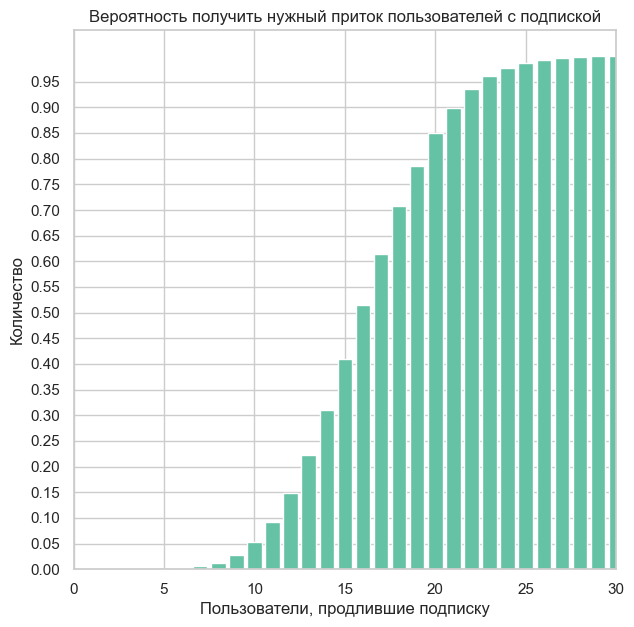

In [46]:
p = 0.1 # вероятность, что клиент продлит подписку
n = 1650 # количество промокодов на бесплатную подписку на месяц 

distr=[] # список, в котором будем хранить значения распределения
t = int(n/10)
for k in range(0, (t + 1)):
    current_value = binom.cdf(k, t, p)
    distr.append(current_value)
    
plt.figure(figsize = (7,7))
plt.title('Вероятность получить нужный приток пользователей с подпиской')
plt.xlabel('Пользователи, продлившие подписку')
plt.ylabel('Количество')
plt.bar(range(0, t + 1), distr)
ticks = []
for i in range (0,100, 5):
    
    ticks.append(i/100)
plt.yticks(ticks)
plt.xlim(0, 30)
plt.show()

In [47]:
print('Вывод:')
print('-'*60)
print(f'Чтобы с вероятностью не менее 95% получить 100 клиентов,')
print(f'продливших подписку, нужно раздать не менее {n} промокодов')

Вывод:
------------------------------------------------------------
Чтобы с вероятностью не менее 95% получить 100 клиентов,
продливших подписку, нужно раздать не менее 1650 промокодов


#### Оценить успешность рассылки

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. 
Клиенты могут открыть его или не открывать. 

- Известно, что уведомления открывают около 40 % получивших клиентов. 
- Отдел планирует разослать 1 млн уведомлений.

- С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Вероятность открыть приложение после push уведомления достаточно велика. Так что можно аппроксимировать ее нормальным распределением.


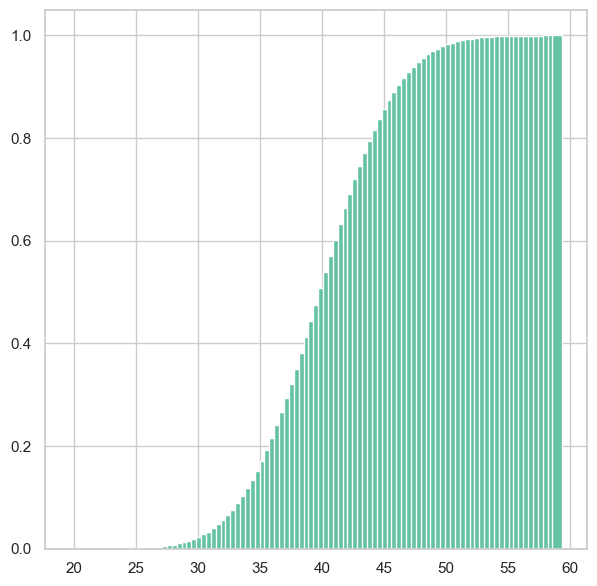

In [48]:
from math import sqrt

# задаём параметры биномиального распределения
n = 1000000
p = 0.4
t=int(n/10000)
# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = t * p
sigma = sqrt(t * p * (1 - p))


# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)

left = int(t * p - 4 * sqrt(t * p * (1 - p)))
right = int(t * p + 4 * sqrt(t * p * (1 - p)))
x = linspace(left, right, 100)
# задаём нормальное распределение
distr = norm.cdf(x, mu, sigma) 

plt.figure(figsize = (7,7))

plt.bar(x, distr)

plt.show()


In [49]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4
x = 399500 # желаемая величина
# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от x
result = distr.cdf(x)
print(f'Вероятность получить не более 399.5 тыс. пользователей - {(result*100).round(2)} %')

Вероятность получить не более 399.5 тыс. пользователей - 15.37 %


### Выводы

Для проведения исследования была получена выборка из генеральной совокупности, а именно данные о некоторых пользователях сервиса проката самокатов GoFast

- Набор данных достаточен для анализа
- Выборка репрезентативна.

В ходе предобработки данных:
- удалены явные дубликаты (31шт)
- в формат времени переведено значение столбца date в датафрейме rides
- добавлен столбец с месяцем поездки

В ходе исследовательского анализа данных было установлено:

- Средний возраст пользователей 25 лет
- Диапазон от 12 до 43 лет
- Среднее расстояние 3133.6 метров, расстояние не превышает 6 км
- Средняя продолжительность поездки 17,6 мин, максимальное значение не превышает 40 минут
- Больше всего поездок в Пятигорске, меньше всего в Москве
- Пользователей без подписки больше

Для проверки гипотез был создан отдельный датафрейм с суммарным расстоянием, количество поездок и суммарным временем для каждого пользователя за каждый месяц.

В ходе проверки гипотез были получены следующие выводы:

- Пользователи с подпиской больше времени тратат на поездки и тем самым более выгодны для сервиса.
- Можно утверждать, что среднее расстояние за одну поездку для пользователей с подпиской не превышает 3130 метров.
- Выручка от пользователей с подпиской выше выручки от пользователей без попдиски.
- Чтобы проверить гипотезу, что после обновления сервера количество обращений в техническую поддержку снизилось нужно провести двухвыборочный ttest для зависимых выборок scipy.stats_ttest(rel)) 

На основании распределений:

- Чтобы с вероятностью не менее 95% получить 100 клиентов, продливших подписку, нужно раздать не менее 1650 промокодов

- Вероятность получить не более 399.5 тыс. откликов - 15.37 % при рассылке в 1млн.